# Audio Digit Classification Supervised Learning Project

## Introduction
   This Supervised Learning project is a Classification Task that aims to predict English digits (0 to 9) using a machine learning model. The Random Forest ensemble method and Support Vector Machine (linear and RBF) methods were both implemented to explore feasibility of those models for this dataset.

## Background
   Although image and audio processing have recently most commonly utilized Convolution Neural Networks models, there is still a benefit to using a simpler machine learning model without the need for exotic types of computing hardware like GPUs. The applications are numerous, where providing speech recognition and classification of digits will enable off-grid systems to still be commanded by voice. With a simpler model, even small systems with no IP connectivity can recognize voice commands and respond. Some examples include smart phone answering systems that can respond to voice commands, voice enabled embedded devices that can operate without an internet connection. Furthermore, this project sets up a framework for implementing further types of classification of speech such as some simple single or two syllable words. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import kagglehub

# Download latest version
path = kagglehub.dataset_download("joserzapata/free-spoken-digit-dataset-fsdd")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/free-spoken-digit-dataset-fsdd


## Implementation
- Most of the heavy lifting for the project is performed in the DigitalRecordings class below. It provides support functions for loading the wav file recordings, cleaning the data, converting the data to various formats, extracting spectrogram features from the data. Finally, the DigitalRecordings class prepares the data for model training and testing for all the samples loaded.
- Under the hood, the DigitalRecordings class uses the Python library librosa to perform most of the data conversion and loading of each individual sample.

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
#for loading and visualizing audio files
import librosa
import librosa.display

names = ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']

n_variants = 50
n_digits = 10
n_persons = len(names)

class DigitRecordings:
    def __init__(self, n_classes):
        self.n_samples = 0
        self.n_classes = n_classes
        self.wav_data = []
        self.raw_X = []
        self.digit = []
        self.X = []
        self.y = []
        self.sr = 0
        self.n_folds = 5

        self.Xmel = []
        self.Xmfcc = []
        self.Xdelta = []
        self.Xdelta2 = []
        self.Xcentroid = []
        self.Xcontrast = []
        self.Xrms = []
        
    def load(self, sr=8000):
        loaded_wav = []
        loaded_wav_test = []
        digit = []
        test_digit = []
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if filename.endswith('.wav') and filename[0].isdigit():
                    wav, sr = librosa.load(os.path.join(dirname, filename), sr=sr)
                    # get the last 10 spoken digit index (spoken digit 40-49)
                    spoken_index = filename.split('.')[0][-2:]
                    if spoken_index.isdigit() and int(spoken_index) >=40:
                        loaded_wav_test.append(wav)
                        test_digit.append(int(filename[0]))
                    else:
                        loaded_wav.append(wav)
                        digit.append(int(filename[0]))
        self.wav_data = loaded_wav + loaded_wav_test
        self.digit = digit + test_digit
        print(f'Number of recordings {len(self.wav_data)} with recording size {self.wav_data[0].size}')
        print(f'Number of test recordings {len(loaded_wav_test)}')
        self.sr = sr

        return loaded_wav
        
    def discard_big_samples(self, limit):
        new_wav = []
        new_digit = []
        for i, wav in enumerate(self.wav_data):
            if len(wav) < limit:
                new_wav.append(wav)
                new_digit.append(self.digit[i])
        self.wav_data = new_wav
        self.digit = new_digit
        return new_wav
        
    def pad_wave(self, loaded_wav):
        ## Pad the wav files to same size for feature extraction. The recordings have different lengths.
        process_wav = []
        # Pad at the end
        pad_size = max([x.size for x in loaded_wav])
        print(pad_size)
        for x in loaded_wav:
            process_wav.append(librosa.util.fix_length(x, size=pad_size))

        self.wav_data = process_wav

    def feature_extract(self, algo=['mfcc'], padding='end', normalize=False):
        # convert data

        # initialize the np arrays for all features, using mfcc as the template

        n_samples = len(self.wav_data)
        mfcc_data = librosa.feature.mfcc(y=self.wav_data[0], sr=8000, n_fft=512)
        n_mfcc_components = mfcc_data.shape[0]
        n_duration = mfcc_data.shape[1]        

        centroid_data = librosa.feature.spectral_centroid(y=self.wav_data[0], sr=8000, n_fft=512)
        n_centroid_components = centroid_data.shape[0]

        contrast_data = librosa.feature.spectral_contrast(y=self.wav_data[0], sr=8000, n_fft=512, fmin=50)
        n_contrast_components = contrast_data.shape[0]
        
        self.Xmfcc = np.zeros((n_samples, n_mfcc_components, n_duration))
        self.Xdelta = np.zeros((n_samples, n_mfcc_components, n_duration))
        self.Xdelta2 = np.zeros((n_samples, n_mfcc_components, n_duration))
        self.Xcentroid = np.zeros((n_samples, 1, n_duration))
        self.Xcontrast = np.zeros((n_samples, n_contrast_components, n_duration))
        self.Xrms = np.zeros((n_samples, 1, n_duration))
        
        n_samples = len(self.wav_data)

        n_combined = 0
        
        # determine size of combined features
        for feature in algo:
            if feature == 'mfcc':
                n_combined += n_mfcc_components
            elif feature == 'delta':
                n_combined += n_mfcc_components
            elif feature == 'delta2':
                n_combined += n_mfcc_components
            elif feature == 'centroid':
                n_combined += 1
            elif feature == 'contrast':
                n_combined += n_contrast_components
            elif feature == 'rms':
                n_combined += 1

        self.Xcombined = np.zeros((n_samples, n_combined, n_duration))
        
        for i,wav in enumerate(self.wav_data):
            j = 0
            for feature in algo:
                if feature == 'mfcc': 
                    mfcc_data = librosa.feature.mfcc(y=wav, sr=8000, n_fft=512)
                    self.Xmfcc[i,:,:] = mfcc_data
                    self.Xcombined[i,j:j+n_mfcc_components,:] = mfcc_data
                    j += mfcc_data.shape[0]
                elif feature == 'delta': # mfcc must be calculated first
                    delta_data = librosa.feature.delta(mfcc_data)
                    self.Xdelta[i,:,:] = delta_data                    
                    self.Xcombined[i,j:j+n_mfcc_components,:] = delta_data
                    j += delta_data.shape[0]
                elif feature == 'delta2': # mfcc must be calculated first
                    delta2_data = librosa.feature.delta(mfcc_data, order=2)
                    self.Xdelta2[i,:,:] = delta2_data
                    self.Xcombined[i,j:j+n_mfcc_components,:] = delta2_data
                    j += delta2_data.shape[0]
                elif feature == 'centroid':
                    centroid_data = librosa.feature.spectral_centroid(y=wav, sr=8000, n_fft=512)
                    self.Xcentroid[i,:,:] = centroid_data
                    self.Xcombined[i,j:j+1,:] = centroid_data
                    j += centroid_data.shape[0]
                elif feature == 'contrast':
                    contrast_data = librosa.feature.spectral_contrast(y=wav, sr=8000, n_fft=512, fmin=50)
                    self.Xcontrast[i,:,:] = contrast_data
                    self.Xcombined[i,j:j+n_contrast_components,:] = contrast_data
                    j += contrast_data.shape[0]
                elif feature == 'rms':
                    rms_data = librosa.feature.rms(y=wav)
                    self.Xrms[i,:,:] = rms_data
                    self.Xcombined[i,j:j+1,:] = rms_data
                    j += rms_data.shape[0]
                else:
                    pass

        x_samples, x_size, y_size = self.Xcombined.shape
        self.X = self.Xcombined.reshape(x_samples, x_size*y_size)
        self.y = np.array(self.digit)            

        return self

    def convert_stft(self):
        Xstft = []
        for wav in self.wav_data:
            stft_data = librosa.stft(wav, n_fft=512) # n_fft reduced from default 2048 to get rid of warnings
            db_data = librosa.amplitude_to_db(np.absolute(stft_data))
            Xstft.append(db_data)
        return Xstft

    def convert_melspectrogram(self):
        Xmel = []
        for wav in self.wav_data:
            mel = librosa.power_to_db(librosa.feature.melspectrogram(y=wav, n_fft=512))
            Xmel.append(mel)
        return Xmel
        

# Dataset
   The dataset used is called the Free Spoken Digit Dataset (FSDD), which is available on Kaggle. The dataset provides recordings of spoken digits in wav format recorded at 8kHz sampling rate. The dataset currently has 3000 recorded samples with 6 speakers repeating each digit 50 times. This means that the dataset is balanced with equal amounts of samples for each spoken digit. The typical length of the wav file is about 3.5 seconds with several samples over 18 seconds in length. Some of these large file outliers were removed as part of data cleaning in this project.

In [3]:
# Load the recordings from the FSDD dataset with n classifications set to 10
dr = DigitRecordings(10)
dr.load()
print()

Number of recordings 3000 with recording size 3540
Number of test recordings 600



# Data Cleaning

## Padding the Data

During development of the project, manual exploratory analysis of the data showed that not all of the files were of equal length. For feature extraction and model fitting, the size of the data has to be uniform across all samples. A 'pad at the end' implementation was used, as it will allow a consistent start time for the speech for all samples, while the end of the speech will have different amounts of padded zeros across different samples. However, since the padding is at the end, this padding should not affect model quality.

## Removal of outliers in the data
  
To better understand the data, a histogram is plotted to visualize the quantity of samples that are large wav files. Through observation of the histogram, it was determined that there were a few outliers with long recording times, with the largest about 18 seconds. Outliers were removed in order to be able to reduce the required size of the padding of the wav files. A cutoff of 7.5 seconds was selected for removal of outliers, which resulted in 59% size reduction in the padded wav recordings while only discarding 0.9% of the samples. The sample size is reduced from 3000 to 2972. Without the removal of the outliers, the data with zero padding will be part of the dataset and will unnecessarily slow down the model training process with limited training benefit (0.9% extra samples added).

3000
28
Max duration 18262
Mean Duration is 3499.4746666666665
Percentage Samples To Discard is 0.9333333333333335%
Percentage Size reduction is 58.93111378819407%


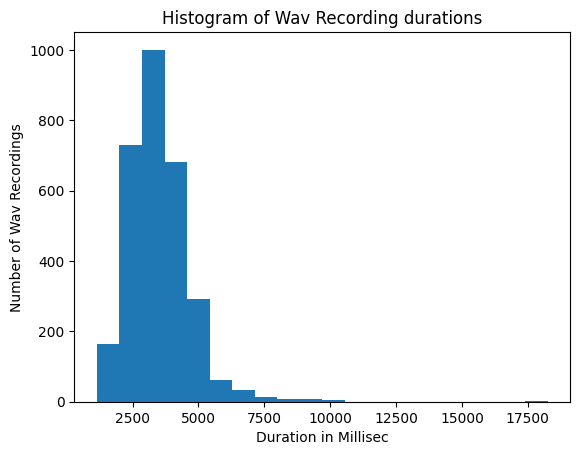

In [4]:
# Plot histogram of size of wav files  

n_bins = 20
dist = [x.size for x in dr.wav_data]

# We can set the number of bins with the *bins* keyword argument.
plt.hist(dist, bins=n_bins)
plt.title('Histogram of Wav Recording durations')
plt.xlabel('Duration in Millisec')
plt.ylabel('Number of Wav Recordings')
count=0
for x in dist:
    if x > 7500:
        count = count+1

print(len(dist))
print(count)
max_duration = max([x.size for x in dr.wav_data])
mean_duration = sum([x.size for x in dr.wav_data])/len(dr.wav_data)
size_reduced = (max_duration-7500.0)/max_duration
print('Max duration ' + str(max_duration))
print('Mean Duration is ' + str(mean_duration))
print('Percentage Samples To Discard is ' + str(count/len(dist)*100) + "%")
print('Percentage Size reduction is ' + str(size_reduced*100.0) + "%")

plt.show()

In [5]:
# Discard the large samples with time > 7.5 seconds
new_wav = dr.discard_big_samples(7500)
print(len(new_wav))

# Pad the end of the wav files with zeros for all the remaining samples
dr.pad_wave(new_wav)

2972
7396


# Exploratory Data Analysis

## Overview
- As the dataset are wav file recordings, we first have to perform a Short Term Fourier Transform (STFT) spectrogram and extract features from the spectrogram. This is a widely used technique for speech recognition. In order to perform the conversion, the librosa python framework is used. Several STFT samples are plotted to visualize and explore the data.
- The features initially extracted are the  Mel-Frequency Cepstral Coefficients (MFCC), Delta derivative of the MFCC, 2nd order Delta derivative of the MFCC, Spectral Centroid, Spectral Contrast and Root Mean Square (RMS) of the signal. These were selected from the potential functions from librosa for their applicability toward speech recognition. In particular, the MFCC, Delta and 2nd order Delta features are focused on frequencies in the range of normal speech. The Spectral Centroid, Spectral Contrast and RMS help to provide additional signals on the peak intensity and energy of the speech.
- Forward selection will be used to incrementally add features for incremental improvements to the classification score. Thru feature exploration and experimentation, it was discovered that the MFCC produced a relatively high accuracy and incremental features did not improve accuracy scores significantly. Several features such as Delta, Delta2 and Spectral Contrast did add significant amount of training time. Hence it was chosen to utilize MFCC and Spectral Centroid as the features. 
- As the MFCC features are multi dimensional, we are not able to generate a correlation matrix directly to determine correlation between the features. Instead, we will use Canonical Correlation Analysis (CCA) in order to determine correlation between features. Another possibilty to reduce training time would be to reduce the number of MFCC coefficients from the default of 20 in order to simplify the model further.
	

## Visualization of Short Time Fourier Transform (STFT) amplitude DB-scaled spectrogram
- For audio data, interpreting the data as a spectrogram generally provides more detail for analysis as it splits the signal into time, amplitude and frequency components. Below are a few examples of a generated Short Term Fourier Transform (STFT) spectrogram from the training samples. Note that the ends are padded with zeros and show a block of solid color.

<Figure size 640x480 with 0 Axes>

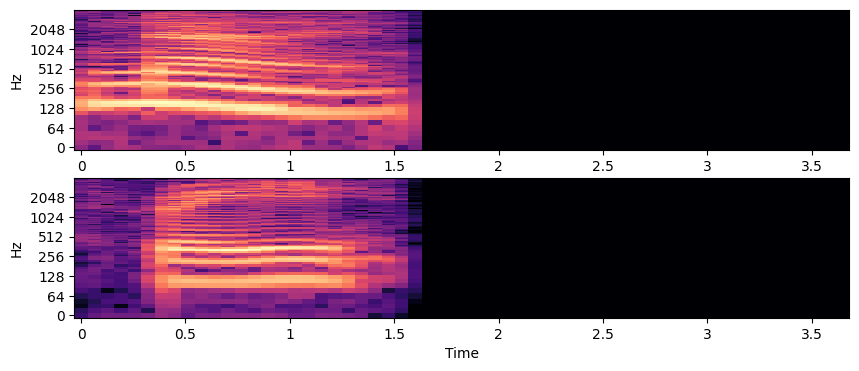

In [6]:
plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

stft_data = dr.convert_stft()
librosa.display.specshow(stft_data[801], sr=dr.sr, x_axis='time', ax=ax[0], n_fft=512, y_axis='log')
librosa.display.specshow(stft_data[951], sr=dr.sr, x_axis='time', ax=ax[1], n_fft=512, y_axis='log')


## Visualization of Mel Spectrogram and Mel-Frequency Cepstral Coefficients (MFCC) Spectrogram 
- As part of feature extraction, the STFT data is converted to Mel Spectrogram and Mel-Frequency Cepstral Coefficients (MFCC) spectrogram.
- It is interesting to note that the intensity of the data are around the same regions as the STFT spectrogram, which provides visual evidence that the features are being extracted from the data correctly

<Figure size 640x480 with 0 Axes>

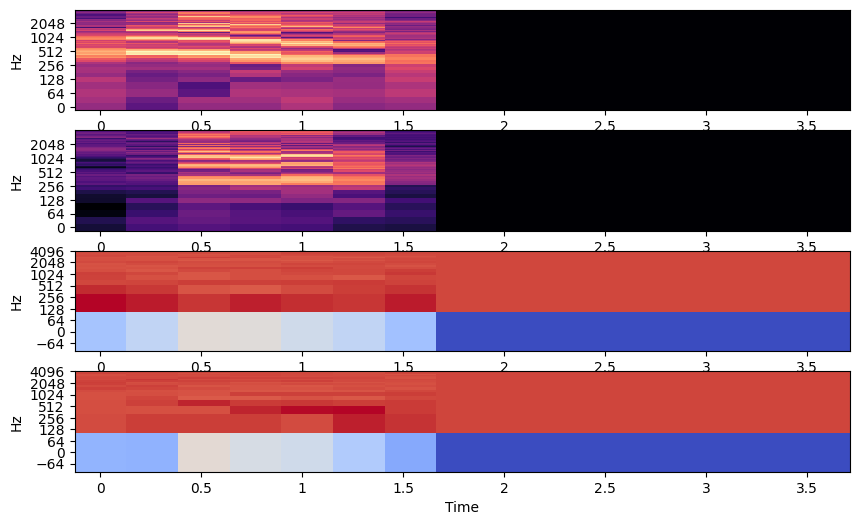

In [7]:
plt.figure()
fig, ax = plt.subplots(4, 1, figsize=(10, 6))

mel_data = dr.convert_melspectrogram()
librosa.display.specshow(mel_data[801], sr=dr.sr, x_axis='time', ax=ax[0], y_axis='log', hop_length=2048)
librosa.display.specshow(mel_data[951], sr=dr.sr, x_axis='time', ax=ax[1], y_axis='log', hop_length=2048)

dr = dr.feature_extract(algo=['mfcc'])
librosa.display.specshow(dr.Xmfcc[801], sr=dr.sr, x_axis='time', ax=ax[2], y_axis='log', hop_length=2048)
librosa.display.specshow(dr.Xmfcc[951], sr=dr.sr, x_axis='time', ax=ax[3], y_axis='log', hop_length=2048)

## Split Training data to provide 20% as tests
- To further explore the data and extract useful features for the model, the dataset is split to 80% for training and 20% for test. Recall that 20% of the samples (spoken index 40 to 49) were located at the end of the list of recordings. Some samples were discarded in the test set, but the overall training set and test set should remain somewhat balanced. Random train/test split was not used in order to keep the training and test dataset balanced across all speakers and digits.

In [8]:
def get_split(dr):
    # we split the training set to 0.8 of the full set
    # Recall
    split_index = int(dr.X.shape[0]*0.8)
    X_train = dr.X[:split_index]
    X_test = dr.X[split_index:]
    y_train = dr.y[:split_index]
    y_test = dr.y[split_index:]
    return (X_train, X_test, y_train, y_test)

In [9]:
X_train, X_test, y_train, y_test = get_split(dr)
print(len(X_train))
print(len(X_test))

2377
595


## Feature Selection and Importance
- The features initially extracted are the MFCC, MFCC Delta, MFCC Delta 2, Spectral Centroid, Spectral Contrast and Root Mean Square spectral energy (RMS). The details of each of these features are beyond the scope of this notebook. However, it is good to note that these features were selected from the potential features from librosa for their applicability toward speech recognition. In particular, the MFCC features are focused on frequencies in the range of normal speech. The Spectral Centroid, Spectral Contrast and RMS help to provide additional signals on the peak intensity and energy of the speech.
- Forward selection was used to incrementally add features and statistical tests performed on the model at each incremental feature set. It was discovered that the MFCC by itself already produced a relatively high precision, recall and F1-score values. The addition of other  features did not improve scores significantly.  
- The duration taken to fit the model as more features were added was also plotted. From the plot, it could be observed that Delta, Delta2 and Spectral Contrast added a significant duration to the fit time. With that result and the features not improving the F1-score values, these features were not selected for this project.
- Spectral Contrast did **not** add significant amount of training time as it is a single value for each STFT time window. The MFCC has 20 components for each time window, but provides a baseline for features extracted from the STFT. Hence, MFCC and Spectral Centroid were selected as the features for this project.


In [10]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
algo=['mfcc', 'centroid', 'delta', 'delta2', 'contrast']

fscores = []
precisions = []
recalls = []

for i in range(1,len(algo)+1):
    dr = dr.feature_extract(algo=algo[:i])
    clf = RandomForestClassifier(random_state=12)
    X_train, X_test, y_train, y_test = get_split(dr)
    %time clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision, recall, fscore, suppot = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
    fscores.append(fscore)
    precisions.append(precision)
    recalls.append(recall)
    
    print(
        f"Metrics report for algos {algo[:i]}:\n"
#        f"{metrics.classification_report(y_test, y_pred)}\n"
        f"Precision: {precision}\n"
        f"Recall: {recall}\n"
        f"F-Score: {fscore}\n"
    )

CPU times: user 1.66 s, sys: 5.88 ms, total: 1.67 s
Wall time: 1.66 s
Metrics report for algos ['mfcc']:
Precision: 0.9694600898840975
Recall: 0.9680771478667447
F-Score: 0.9683292803768342

CPU times: user 1.64 s, sys: 1.89 ms, total: 1.64 s
Wall time: 1.64 s
Metrics report for algos ['mfcc', 'centroid']:
Precision: 0.9763761865374768
Recall: 0.974772063120982
F-Score: 0.9750503261318061

CPU times: user 2.82 s, sys: 3.88 ms, total: 2.82 s
Wall time: 2.82 s
Metrics report for algos ['mfcc', 'centroid', 'delta']:
Precision: 0.9690732208780023
Recall: 0.9680206506916035
F-Score: 0.9681973362604855

CPU times: user 3.67 s, sys: 5.9 ms, total: 3.67 s
Wall time: 3.67 s
Metrics report for algos ['mfcc', 'centroid', 'delta', 'delta2']:
Precision: 0.9659745694688617
Recall: 0.9647155659458407
F-Score: 0.9648958100631717

CPU times: user 3.92 s, sys: 1.92 ms, total: 3.92 s
Wall time: 3.92 s
Metrics report for algos ['mfcc', 'centroid', 'delta', 'delta2', 'contrast']:
Precision: 0.9704542416771

<Figure size 640x480 with 0 Axes>

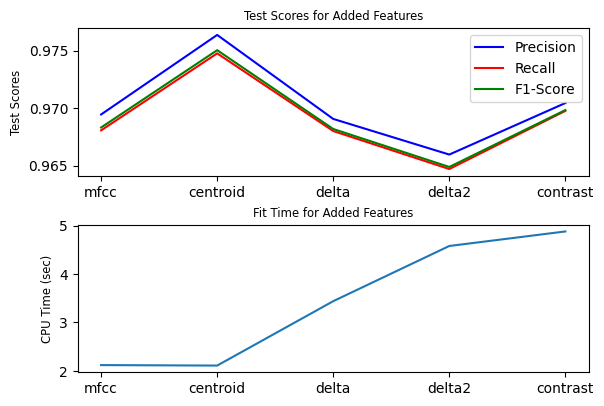

In [11]:

cpu_time = [2.12, 2.11, 3.44, 4.58, 4.88] # This was taken from previous runs and may not match 100% with all runs

plt.figure()
features = ['mfcc', 'centroid',  'delta', 'delta2', 'contrast']
fig, ax = plt.subplots(2, 1, figsize=(6, 4))

ax[0].set_title('Test Scores for Added Features', fontsize='small')
ax[0].set_ylabel('Test Scores', fontsize='small')
ax[0].plot(features, precisions, color='blue', label='Precision' )
ax[0].plot(features, recalls, color='red', label='Recall')
ax[0].plot(features, fscores, color='green', label='F1-Score')
ax[0].legend()

ax[1].set_title('Fit Time for Added Features', fontsize='small')
ax[1].set_ylabel('CPU Time (sec)', fontsize='small')
ax[1].plot(features, cpu_time)

plt.tight_layout(pad=0.5)

In [12]:
print(dr.Xmfcc.shape)

(2972, 20, 15)


## Correlation between MFCC Coefficients and Spectral Centroid

As the MFCC Coefficients and Spectral Centroid are the two features in the training data, some  analysis was needed to determine if there is significant correlation between the two features. As the MFCC is a multidimensional data (20 coefficients for each time window), the usual tools for computing correlation matrix are not suitable.

Hence, a more advanced technique called the Canonical Correlation Analysis (CCA) was used to determine correlation between the MFCC Coefficients and the Spectral Centroid. The CCA approach computes the correlation relationship between multidimensional datasets. The details of CCA are too advanced for this notebook, but in brief, the CCA analysis will return two arrays where the first row of each array contain the components of the first feature that are most highly correlated with the second feature. The relationship between the two highly correlated vectors can be plotted in a scatter plot to visualize the correlation between the data.


(2972, 20, 15)
2972
(2972, 1, 15)


<Figure size 640x480 with 0 Axes>

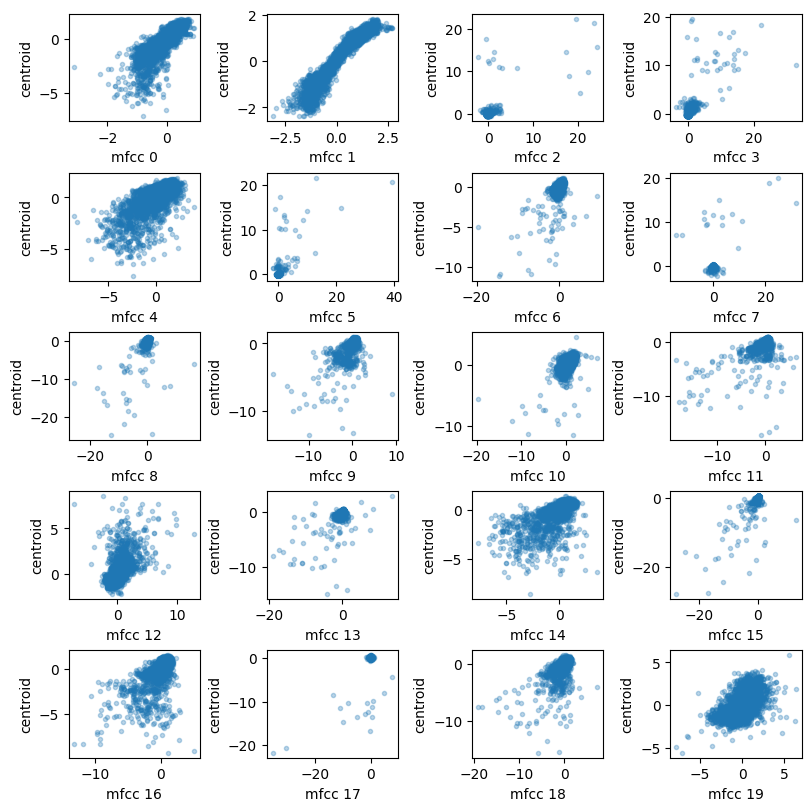

In [13]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=2)
print(dr.Xmfcc.shape)
print(dr.Xmfcc.shape[0])
print(dr.Xcentroid.shape)

plt.figure()
features = ['mfcc', 'centroid',  'delta', 'delta2', 'contrast']
fig, ax = plt.subplots(5, 4, figsize=(8, 8), layout="constrained")

n_samples = dr.Xmfcc.shape[0]
Xcentroid = dr.Xcentroid.reshape(n_samples, dr.Xcentroid.shape[2])

col = 0
for i in range(5):
    for j in range(4):
        Xmfcc = dr.Xmfcc[:,i*4+j,:].reshape(n_samples, dr.Xmfcc.shape[2])
        cca.fit(Xmfcc, Xcentroid)
        Xm_train_r, Xc_train_r = cca.transform(Xmfcc, Xcentroid)
        ax[i, j].set_xlabel('mfcc ' + str(i*4+j))
        ax[i, j].set_ylabel('centroid')
        ax[i, j].scatter(Xm_train_r[:, 0], Xc_train_r[:,0], marker=".", alpha=0.3, label="samples")


### Discussion
Running the CCA analysis, it was determined that there is some correlation between the Spectral Centroid and MFCC Coefficient 1. As the initial data exploration found that the model performance slightly improved with the addition of the Spectral Centroid, the feature was included as part of the final model training.

# Model

## Overview
- The Random Forest, Linear SVM, RBF SVM models were explored for classification of the dataset. For each model, cross validation on 5 folds was performed. Each model also utilized hyper parameter tuning that is appropriate for the model. To accomplish this, the sklearn GridSearchCV function was utilized with varying hyper parameter values and a K-fold value of 5. This will provide about 475 samples for each fold from a training set of almost 2388 (80% of 2972 )

## Grid Search for Random Forest Ensemble Method
- Grid Search was performed for the Random Forest method with a varying number of trees in the forest (n_estimators). Several other parameters were experimented with manually, but performed significantly worse than the default. For example, the minimum samplesl required to be a leaf node (min_sample_leaf) was always optimal at 1 and the maximum depth of the tree (max_depth) was always optimal at None. In order to reduce the compute time, only the n_estimators was varied in the grid search.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import pickle

#small_parameters = {'min_samples_leaf': [1, 5],
#                  'max_depth': [None, 5], 
#                  'n_estimators': [100, 200]}

# min samples leaf were always optimal at 1 and max depth optimal at None

parameters = {'n_estimators': np.linspace(800, 1600, 20, dtype=int)}

dr = dr.feature_extract(algo=['mfcc', 'centroid'])
X_train, X_test, y_train, y_test = get_split(dr)

random_forest = RandomForestClassifier()

grid = GridSearchCV(estimator=random_forest, cv=dr.n_folds, param_grid=parameters, n_jobs=8, verbose=10)

grid = grid.fit(X_train, y_train)

print(f'Best Score: ' + str(grid.best_score_))
print(f'Best Params: ' + str(grid.best_params_))

# Save model results for future analysis
with open(f'random_forest.pkl','wb') as f:
    pickle.dump(grid,f)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score: 0.9777072091994693
Best Params: {'n_estimators': 1600}


## Grid Search for Linear SVM
- Grid Search was performed for the Linear SVM method with a varying value of the regularization parameter C. The Grid Search was performed using varying values of C and cross validated with a K-fold value of 5. 

In [15]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import pickle

parameters = {'C': np.logspace(-8, -2, num=20, base=10.0)}

dr = dr.feature_extract(algo=['mfcc', 'centroid'])
X_train, X_test, y_train, y_test = get_split(dr)
linear_svc = LinearSVC(max_iter=100000) # increase max_iter because Liblinear failed to converge

grid = GridSearchCV(estimator=linear_svc, cv=dr.n_folds, param_grid=parameters, n_jobs=8, verbose=10)

grid = grid.fit(X_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Best Params: {grid.best_params_}')

# Save model results for future analysis
with open(f'linear_svm.pkl','wb') as f:
    pickle.dump(grid,f)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score: 0.9528881026094649
Best Params: {'C': 6.158482110660255e-05}


## Grid Search for SVM RBF 
- Grid Search was performed for the RBF SVM method with a varying value of regularization parameter C and gamma. Initial experiments with Grid Search when using varying values of gamma led to very poor model performance (< 50% accuracy). After some investigation, it was determined that the RBF kernel is susceptible to features with high variance and values which could dominate the objective function. To correct this, the data was standardized to remove the mean and scaling to unit variance using the sklearn StandardScaler function. The gamma function was also scaled to by the number of features in the dataset to set it to an initial value near to the 'auto' gamma setting.
- From there, the GridSearchCV function was used as in other models, to search the grid of varying C and gamma values. As there are two hyperparameters being tuned, a heatmap is generated to visualize the tuned grid.

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()

#parameters = {'C': np.logspace(1, 4, num=20, base=10.0)}
# gamma = ['scale', 'auto']

dr = dr.feature_extract(algo=['mfcc', 'centroid'])
X_train, X_test, y_train, y_test = get_split(dr)

X_train_scaled = scaler.fit_transform(X_train)

n_features = X_train.shape[1]

# We scale the gamma by n_features to be in the same region as the 'auto' setting
parameters = {'C': np.logspace(-3, 3, num=10, base=10.0),
              'gamma': np.logspace(-5, 5, num=10, base=2.0)/n_features}

svm = SVC(kernel='rbf')

grid = GridSearchCV(estimator=svm, cv=dr.n_folds, param_grid=parameters, n_jobs=8, verbose=10)

grid = grid.fit(X_train_scaled, y_train)

print(f'Best Score: ' + str(grid.best_score_))
print(f'SVM-RBF Best Params: ' + str(grid.best_params_))
    
# Save model results for future analysis

with open(f'rbf_svm.pkl','wb') as f:
    pickle.dump(grid,f)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Score: 0.9734957983193278
SVM-RBF Best Params: {'C': 46.41588833612773, 'gamma': 0.00021429756724053692}


# Result and Analysis

## Result and Analysis of Grid Search for Random Forest, Linear SVM and RBF SVM

### Overview

- To visualize the results of the Random Forest and Linear SVM models cross validated using a grid search, a plot of the scores with respect to each Hyperparameter value is generated. In addition, the prediction performance of the model is calculated on the test dataset for each hyperparameter value. 
- For the SVM RBF model, where there were two hyperparameters tuned (C and gamma), a different visualization approach was used. For this model, a heatmap of the Validation scores from the grid search is shown instead. From the heatmap, it is clear to observe that the grid search recommendation for the best performing model is consistent with the heatmap's visual


### Random Forest classifier Results on 5-Fold Validation and  Test Data
- The Random Forest Classifier grid search selected the number of trees as 1010 that produced a 5-Fold validated F1-score of 0.98.
- When evaluating the Random Forest Classifier on the unseen test data, the results were slightly lower but in the same 0.97 range, as can be observed in the "Visualization and Prediction Performance" section below

In [17]:
with open(f'random_forest.pkl', 'rb') as f:
    grid = pickle.load(f)

print('Best Random Forest Estimator: ' + str(grid.best_estimator_))
print('Best Score: ' + str(grid.best_score_))
print('Best Params: ' + str(grid.best_params_))
print()

dr = dr.feature_extract(algo=['mfcc', 'centroid'])
X_train, X_test, y_train, y_test = get_split(dr)
rf_scores = []
for n_est in np.linspace(800, 1600, 20, dtype=int):
    rf = RandomForestClassifier(n_estimators=n_est, random_state=10)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
    rf_scores.append(fscore)
#print('CV Results: ')
#print(grid.cv_results_)

Best Random Forest Estimator: RandomForestClassifier(n_estimators=1600)
Best Score: 0.9777072091994693
Best Params: {'n_estimators': 1600}



### Linear SVM Classifier Results on Test Data
- The Linear SVM Classifier selected the C parameter as 0.00006 to achieve a best 5-fold cross validated F1-score of 0.95. Note that the solver for the model failed to converge, but it did end up with a decent score.
- When evaluating the model on unseen test data, the score was slightly lower as can be observed in the plot in the "Visualization and Prediction Performance of Random Forest and Linear SVM" section below

In [18]:
import pickle

with open(f'linear_svm.pkl', 'rb') as f:
    grid = pickle.load(f)

print('Best LinearSVC Estimator: ' + str(grid.best_estimator_))
print('Best Score: ' + str(grid.best_score_))
print('Best Params: ' + str(grid.best_params_))
print()
#print('CV Results: ')
#print(grid.cv_results_)

dr = dr.feature_extract(algo=['mfcc', 'centroid'])
X_train, X_test, y_train, y_test = get_split(dr)
lsvm_scores = []
for c in np.logspace(-8, -2, num=20, base=10.0):
    lsvm = LinearSVC(max_iter=100000, C=c) 
    lsvm = lsvm.fit(X_train, y_train)
    y_pred = lsvm.predict(X_test)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
    lsvm_scores.append(fscore)

Best LinearSVC Estimator: LinearSVC(C=6.158482110660255e-05, max_iter=100000)
Best Score: 0.9528881026094649
Best Params: {'C': 6.158482110660255e-05}



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

### RBF SVM Classifier Results on Test Data
- The RBF SVM Classifier selected the C parameter as 46.4 and gamma as 0.0002 to achieve a best 5-fold cross validated F1-score of 0.97.
- A heatmap of the 5-fold cross validated scores of the parameter grid was generated to visualize how the hyperparameters affect scores. The same C and gamma values were then selected to generate a Confusion Matrix with the unseen test data in the "Visualization and Prediction Performance of SVM RBF" section below.


In [19]:
import pickle

with open(f'rbf_svm.pkl', 'rb') as f:
    grid = pickle.load(f)

print('Best RBF SVM Estimator: ' + str(grid.best_estimator_))
print('Best Score: ' + str(grid.best_score_))
print('Best Params: ' + str(grid.best_params_))
print()
#print('CV Results: ')
#print(grid.cv_results_)

Best RBF SVM Estimator: SVC(C=46.41588833612773, gamma=0.00021429756724053692)
Best Score: 0.9734957983193278
Best Params: {'C': 46.41588833612773, 'gamma': 0.00021429756724053692}



## Visualization and Prediction Performance of Random Forest and Linear SVM
- The accuracy of the Random Forest and Linear SVM were both very high. The Random Forest model test prediction F1-Scores for different hyperparameters were very similar to the scores for the training data. The Linear SVM test prediction F1-scores for different hyperparameters was slightly lower but still very close to the training scores.  

<Figure size 640x480 with 0 Axes>

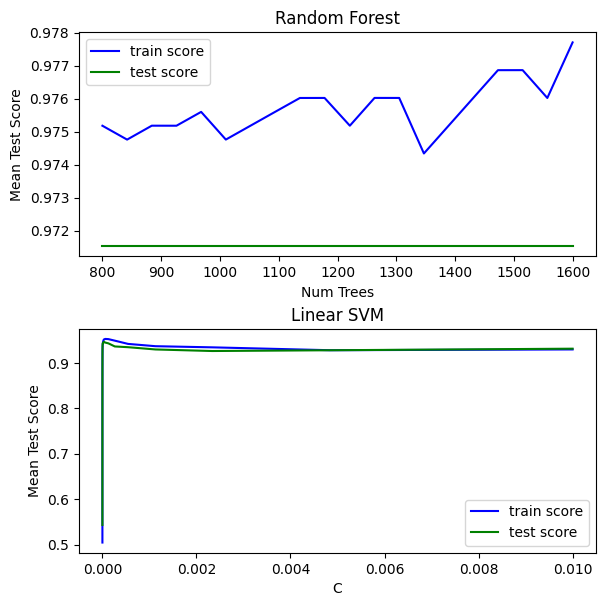

In [20]:
import pickle
#pickle_path = '/kaggle/input/audio-digit-pickle/'

with open(f'random_forest.pkl', 'rb') as f:
    grid_rf = pickle.load(f)

with open(f'rbf_svm.pkl', 'rb') as f:
    grid_rbf_svm = pickle.load(f)

with open(f'linear_svm.pkl', 'rb') as f:
    grid_linear_svc = pickle.load(f)

plt.figure()

fig, ax = plt.subplots(2, 1, figsize=(6, 6))

ax[0].plot([x['n_estimators'] for x in grid_rf.cv_results_['params']],grid_rf.cv_results_['mean_test_score'], 'b', label='train score')
ax[0].plot([x['n_estimators'] for x in grid_rf.cv_results_['params']],rf_scores, 'g', label='test score')

ax[0].set_title('Random Forest')
ax[0].set_xlabel('Num Trees')
ax[0].set_ylabel('Mean Test Score')
ax[0].legend()

ax[1].plot([x['C'] for x in grid_linear_svc.cv_results_['params']],grid_linear_svc.cv_results_['mean_test_score'], 'b', label='train score')
ax[1].plot([x['C'] for x in grid_linear_svc.cv_results_['params']],lsvm_scores, 'g', label='test score')
ax[1].set_title('Linear SVM')
ax[1].set_xlabel('C')
ax[1].set_ylabel('Mean Test Score')
ax[1].legend()


plt.tight_layout(pad=0.5)



## Visualization and Prediction Performance for RBF SVM
- A heatmap of the 5-fold cross validated scores of the parameter grid was generated to visualize how the hyperparameters affect scores. The C=46.6 and gamma=0.0002 value was then selected to generate a Confusion Matrix with the unseen test data in the "Visualization and Prediction Performance of SVM RBF" section below. 

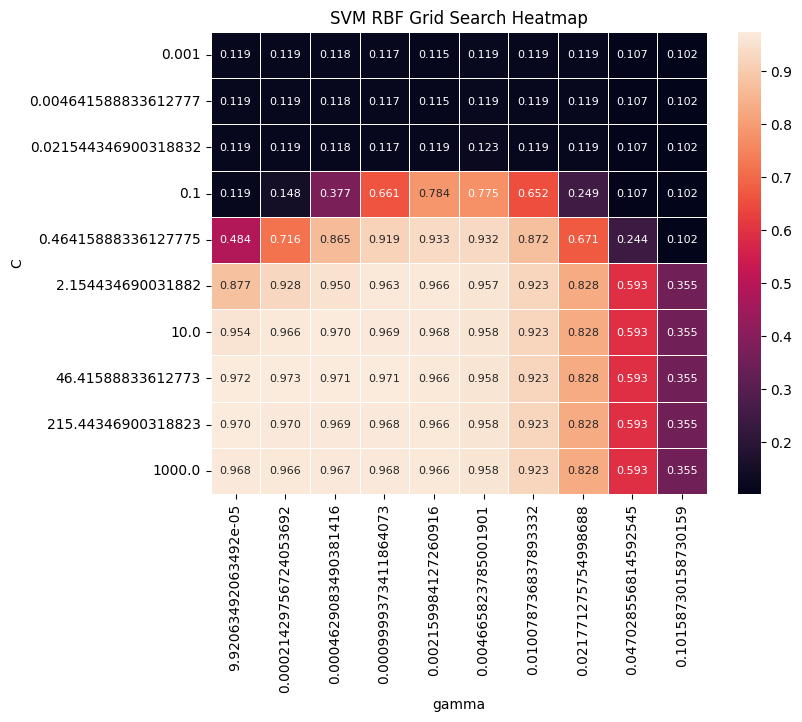

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

with open(f'rbf_svm.pkl', 'rb') as f:
    grid = pickle.load(f)
    
C_list = np.logspace(-3, 3, num=10, base=10.0)
gamma_list = np.logspace(-5, 5, num=10, base=2.0)/315.0
heatmap_scores = grid.cv_results_["mean_test_score"].reshape(len(C_list), len(gamma_list))
f, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(heatmap_scores, annot=True, fmt=".3f", linewidths=.5, ax=ax, yticklabels=C_list, xticklabels=gamma_list, annot_kws={"fontsize":8})
ax.set_title('SVM RBF Grid Search Heatmap')
ax.set_xlabel('gamma')
ax.set_ylabel('C')
print()

## Confusion Matrix for SVM RBF Model
- A Confusion Matrix of the SVM RBF model is generated with the test data. The F1-score of the SVM RBF with tuned hyperparameter is very high, at 0.97. The score for the digit 6 the lowest lower at 0.93, and it appears to be due to the model misclassifying several digits as a 6. Of these, the digit 8 is misclassified four times as a 6 in the test data.

CPU times: user 290 ms, sys: 998 µs, total: 291 ms
Wall time: 285 ms
Classification report for classifier SVC(C=46.4, gamma=0.0002):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.95      0.97        59
           2       1.00      0.97      0.98        58
           3       0.95      0.98      0.97        60
           4       0.98      1.00      0.99        59
           5       0.98      0.97      0.97        60
           6       0.92      0.93      0.93        60
           7       0.92      0.97      0.94        60
           8       0.98      0.93      0.96        60
           9       0.98      0.98      0.98        59

    accuracy                           0.97       595
   macro avg       0.97      0.97      0.97       595
weighted avg       0.97      0.97      0.97       595




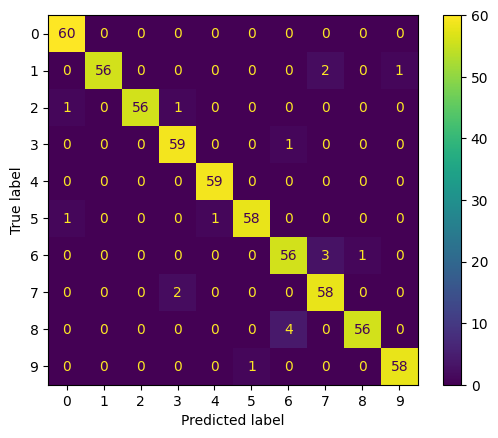

In [22]:
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Generate confusion matrix

clf = SVC(kernel='rbf', C=46.4, gamma=0.0002)

dr = dr.feature_extract(algo=['mfcc', 'centroid'])

X_train, X_test, y_train, y_test = get_split(dr)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

%time clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)

plt.rcParams['axes.grid'] = False

cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[0,1,2,3,4,5,6,7,8,9])

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, y_pred)}\n"
)
disp.plot()
plt.show()


## Fit Time for different models
- The cross validation F1-score performance for all the models were very good at over 0.95. However, there is a large disparity in training time for the different models. The RBF SVM model in particular took significantly less time to train. There could be various reasons for this, but it is possible that the support vectors are easy to identify and calculate. Thus the RBF SVM model will be selected for this project using the hyperparameters determined from the Grid Search cross validation stage (C=46.41 and gamma=0.0002)

<Figure size 640x480 with 0 Axes>

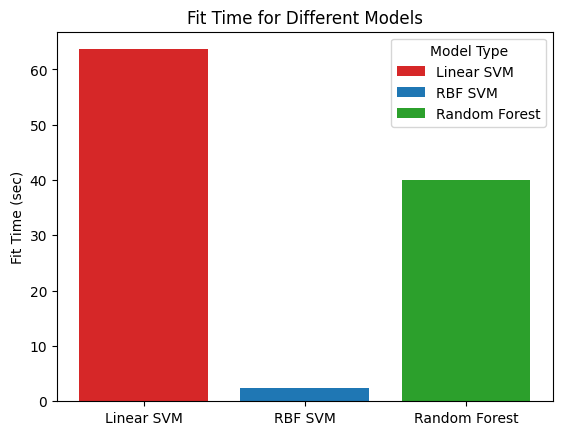

In [23]:
plt.figure()
#plt.plot(grid_linear_svc_stft.cv_results_['mean_fit_time'], 'r')
#plt.plot(grid_rbf_svm_mel.cv_results_['mean_fit_time'], 'b')
fig, ax = plt.subplots()
    
model = ['Linear SVM', 'RBF SVM', 'Random Forest']
time = [np.mean(grid_linear_svc.cv_results_['mean_fit_time']),
        np.mean(grid_rbf_svm.cv_results_['mean_fit_time']),
        np.mean(grid_rf.cv_results_['mean_fit_time'])]

bar_labels = ['Linear SVM', 'RBF SVM', 'Random Forest']
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(model, time, label=bar_labels, color=bar_colors)


ax.set_ylabel('Fit Time (sec)')
ax.set_title('Fit Time for Different Models')
ax.legend(title='Model Type')

print()

# Conclusion
- SVM with the RBF kernel performed extremely well with a 0.97 F1-Score and took the least amount of time for model training. This is beneficial as the model is scaled up to provide more sample data and classification. As I was not familiar with spectral audio analysis, a lot of effort was made to get familiar with techniques for analyzing audio, especially for speech. In the early stages of the project, several naive choices in feature selection resulted in extremely long training times which would not have been feasible for this project. In particular, trying to train with wav data and STFT data directly without proper feature extraction resulted in more than ten times higher model fit/training times.
- In terms of weaknesses, although the SVM RBF appears to be an extremely accurate model, there are some weaknesses in its current form. For one, the dataset used to train the model is balanced in number of digits spoken per person. However, the sample is not a representative sample of a typical population. In particular, there are no female voices in the dataset, and there are no voices with different accents. A possible way to improve the performance of the model across the board would be to obtain more diverse data samples for training and validation. The dataset with the RBF model also is not easy to visualize the decision boundary and slack, as the dataset is multi dimensional. Further investigation in this area could yield ways to visualize how well the model fits the data. 
- Lastly, to further improve the performance of audio speech recognition, it would be necessary to obtain a larger dataset, which would increase training time. At that juncture, it is possible that a different type of compute strategies would need to be employed, such as distributing compute across multiple machines and partial model fitting to incrementally fit the model.

# References
- Jakobovski. (2018). Free Spoken Digit Dataset (FSDD) (v1.0.8)[Dataset]. Kaggle.
     - https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd
 
- Mel-frequency cepstrum. (2019, December 21). Wikipedia.
     - https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

- librosa
     - https://librosa.org/doc/latest/index.html

# Github Link
- https://github.com/7efftan/Audio-Digit-Supervised-Learning/tree/main